In [42]:
# Setting the environment variables

In [43]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [44]:
# Spark environment
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [45]:
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import squarify
import matplotlib.dates as dates
from datetime import datetime

%matplotlib inline

In [47]:
import pandas as pd

In [48]:
import warnings
warnings.filterwarnings('ignore')

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference



### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession


The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number. You can refer to notebook 1 for the steps involved here.

In [49]:
# Loading the clean data

cleaned_df = pd.read_csv("cleaned_df.csv")

## Task 3: Model Selection
3 models for classification:	
- Logistic Regression
- Decision Tree
- Random Forest

### Model 3: Random Forest

#### Feature Transformation (Code will be same; check for the columns)

In [50]:
# Check if only the required columns are present to build the model
# If not, drop the redundant columns

cleaned_df = cleaned_df.drop(cleaned_df.columns[[0,6]], axis=1)

In [51]:
cleaned_df.head()

,event_type,product_id,price,user_id,user_session,category_code_level1,category_code_level2,activity_count,hour,weekday,is_purchased
0,purchase,1004856,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone,4,12,Tuesday,1
1,purchase,1002532,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,smartphone,11,12,Tuesday,1
2,purchase,13800054,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture,bathroom,2,12,Tuesday,1
3,purchase,4804055,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,audio,3,12,Tuesday,1
4,cart,1002524,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,electronics,smartphone,4,12,Tuesday,0


In [52]:
# Feature transformation for categorical features

dummy1 = pd.get_dummies(cleaned_df['event_type'], drop_first=True)

# Adding the results to the master dataframe
cleaned_df = pd.concat([cleaned_df, dummy1], axis=1)

In [53]:
cleaned_df.head()

,event_type,product_id,price,user_id,user_session,category_code_level1,category_code_level2,activity_count,hour,weekday,is_purchased,purchase
0,purchase,1004856,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone,4,12,Tuesday,1,1
1,purchase,1002532,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,smartphone,11,12,Tuesday,1,1
2,purchase,13800054,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture,bathroom,2,12,Tuesday,1,1
3,purchase,4804055,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,audio,3,12,Tuesday,1,1
4,cart,1002524,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,electronics,smartphone,4,12,Tuesday,0,0


In [54]:
# Schema of the transformed df

cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363602 entries, 0 to 363601
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   event_type            363602 non-null  object 
 1   product_id            363602 non-null  int64  
 2   price                 363602 non-null  float64
 3   user_id               363602 non-null  int64  
 4   user_session          363602 non-null  object 
 5   category_code_level1  363602 non-null  object 
 6   category_code_level2  363602 non-null  object 
 7   activity_count        363602 non-null  int64  
 8   hour                  363602 non-null  int64  
 9   weekday               363602 non-null  object 
 10  is_purchased          363602 non-null  int64  
 11  purchase              363602 non-null  uint8  
dtypes: float64(1), int64(5), object(5), uint8(1)
memory usage: 30.9+ MB


In [55]:
# Checking the elements of the transformed df - Top 20 rows

cleaned_df.head(20)

,event_type,product_id,price,user_id,user_session,category_code_level1,category_code_level2,activity_count,hour,weekday,is_purchased,purchase
0,purchase,1004856,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone,4,12,Tuesday,1,1
1,purchase,1002532,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,smartphone,11,12,Tuesday,1,1
2,purchase,13800054,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture,bathroom,2,12,Tuesday,1,1
3,purchase,4804055,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,audio,3,12,Tuesday,1,1
4,cart,1002524,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,electronics,smartphone,4,12,Tuesday,0,0
5,purchase,6200687,28.03,548691404,b67cdbcb-b073-4271-b365-803c6fce53b0,appliances,environment,8,12,Tuesday,1,1
6,cart,4804056,161.98,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683,electronics,audio,4,12,Tuesday,0,0
7,purchase,1004932,463.31,555083442,83d12d1a-5452-4fa0-abbb-d9f492f8b562,electronics,smartphone,3,12,Tuesday,1,1
8,cart,1004833,174.76,536415846,685b5b42-f597-4a69-ab4c-ef96a30bc454,electronics,smartphone,7,2,Tuesday,0,0
9,purchase,1004246,736.18,515246296,b7dbae4f-cad3-463e-89ce-41990cf48dea,electronics,smartphone,3,2,Tuesday,1,1


#### Train-test split

In [56]:
# Splitting the data into train and test (Remember you are expected to compare the model later)

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [57]:
from sklearn.model_selection import train_test_split

In [58]:
# Putting feature variable to X
X = cleaned_df.drop(['is_purchased','weekday','purchase','user_id','user_session','category_code_level1','category_code_level2','event_type','product_id'], axis=1)

# Putting predict variable to y
y = cleaned_df['is_purchased']

In [59]:
X.head()

,price,activity_count,hour
0,130.76,4,12
1,642.69,11,12
2,54.42,2,12
3,189.91,3,12
4,515.67,4,12


In [60]:
y.head()

0    1
1    1
2    1
3    1
4    0
Name: is_purchased, dtype: int64

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42 )

In [62]:
# Number of rows in train and test data

rf = RandomForestClassifier(n_estimators=10, max_depth=3,criterion ="gini",random_state=42,bootstrap=True,oob_score=True,warm_start=True)

#### Model Fitting

In [63]:
#%%time
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, oob_score=True,
                       random_state=42, warm_start=True)

In [64]:
rf.oob_score_

0.7217754134236468

In [65]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

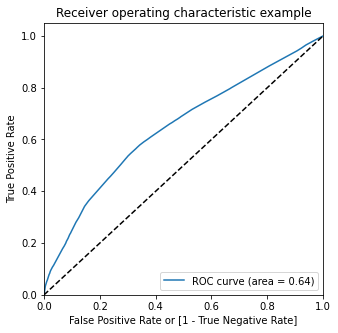

In [66]:
y_train_pred = rf.predict_proba(X_train)

draw_roc(y_train, y_train_pred[:,1])

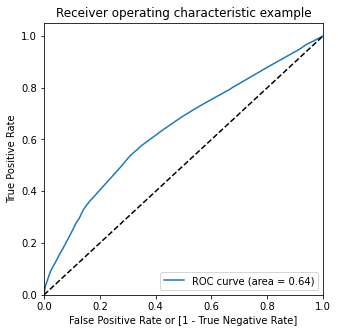

In [67]:
y_test_pred = rf.predict_proba(X_test)

draw_roc(y_test, y_test_pred[:,1])

#### Hyperparameter

In [68]:
from sklearn.model_selection import GridSearchCV


In [69]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [70]:
params = {
    'max_depth': [2,3,5],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

In [71]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [72]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
CPU times: user 15.9 s, sys: 461 ms, total: 16.4 s
Wall time: 5min 33s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [73]:
grid_search.best_score_

0.7256807894703622

In [74]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

#### ROC

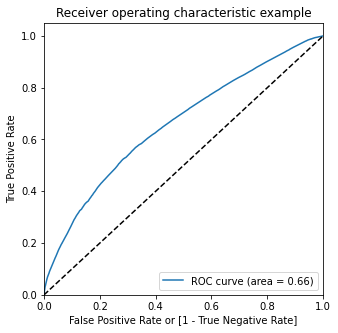

In [75]:
y_train_pred = rf_best.predict_proba(X_train)

draw_roc(y_train, y_train_pred[:,1])

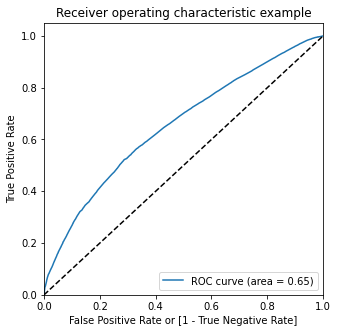

In [76]:
y_test_pred = rf_best.predict_proba(X_test)

draw_roc(y_test, y_test_pred[:,1])

In [77]:
rf_best.feature_importances_

array([0.56468661, 0.43056066, 0.00475274])

In [78]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})

In [79]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
0,price,0.564687
1,activity_count,0.430561
2,hour,0.004753
